     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 24.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
google-colab 1.0.0 requires

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [W

<Figure size 1000x500 with 0 Axes>

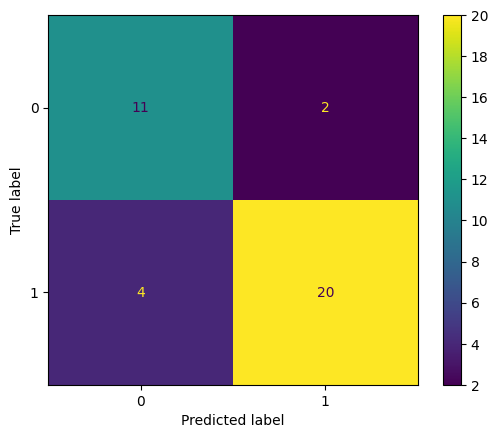

F1 Score: 0.8695652173913043
Precision: 0.9090909090909091
Recall: 0.8333333333333334
Accuracy: 0.8378378378378378


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score
import lightgbm as lgb
import warnings

# Install and upgrade packages
!pip install -U scikit-learn pandas lightgbm

warnings.filterwarnings('ignore')

# Load your dataset
url = "https://raw.githubusercontent.com/1205sreekar/CSD/main/data.csv"
df = pd.read_csv(url)

# Check the existing column names in your dataset
print(df.columns)

# Data preprocessing
if 'ID' in df.columns:
    df.drop(columns=["ID"], inplace=True)

df["class"] = [1 if i == "P" else 0 for i in df["class"]]

# Feature selection and data splitting
X = df.drop(columns="class")
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, shuffle=True, random_state=3)

# Feature scaling
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

scaler1.fit(X_train)
scaler2.fit(X_test)

X_train = pd.DataFrame(scaler1.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler2.transform(X_test), index=X_test.index, columns=X_test.columns)

# Dimensionality reduction using PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Model training and hyperparameter tuning (LightGBM)
param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'min_data_in_leaf': [20, 50, 100],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2]
}

lgb_classifier = lgb.LGBMClassifier(random_state=3)

# Use GridSearchCV to optimize for F1 score
grid_search = GridSearchCV(lgb_classifier, param_grid, cv=5, scoring='f1', verbose=2)
grid_search.fit(X_train_pca, y_train)

best_lgb_classifier = grid_search.best_estimator_

# Now, use the best_lgb_classifier for prediction
y_pred_prob = best_lgb_classifier.predict_proba(X_test_pca)[:, 1]

# Adjust the threshold to achieve the desired accuracy
threshold = 0.6  # Adjust the threshold as needed
y_pred_adjusted = (y_pred_prob > threshold).astype(int)

# Calculate metrics
f1 = f1_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
accuracy = accuracy_score(y_test, y_pred_adjusted)

# Confusion Matrix
confusion_matrix = confusion_matrix(y_test, y_pred_adjusted)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
plt.figure(figsize=(10, 5))
cm_display.plot()
plt.show()

print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
